# 機械学習を使って630万件のレビューに基づいたアニメのレコメンド機能を作ってみよう（機械学習 k近傍法 初心者向け）

# データセットについて（アニメお勧めデータベース）

[Kaggle](https://www.kaggle.com/CooperUnion/anime-recommendations-database)からダウンロードします。

# ライブラリの読み込み

In [1]:
# 使用するライブラリのインポート
import pandas as pd
import numpy as np 
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
# CSVファイルをデータフレーム形式として読み込み
# 保存先が異なる場合はパスも指定してあげましょう
ratings = pd.read_csv('rating.csv')
anime = pd.read_csv('anime.csv')

In [3]:
# ratingのデータフレームの最初の5行を表示
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
# animeデータフレームの最初の五行を表示
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
# animeのデータフレームをmemberの値で並び替え
anime.sort_values('members', ascending= False)[:10]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


In [7]:
# animeの基本統計量の確認
round(anime.describe(),2)

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


In [8]:
# ratingsの基本統計量の確認
round(ratings.describe(),2)

,user_id,anime_id,rating
count,7813737.00,7813737.00,7813737.00
mean,36727.96,8909.07,6.14
std,20997.95,8883.95,3.73
min,1.00,1.00,-1.00
25%,18974.00,1240.00,6.00
50%,36791.00,6213.00,7.00
75%,54757.00,14093.00,9.00
max,73516.00,34519.00,10.00


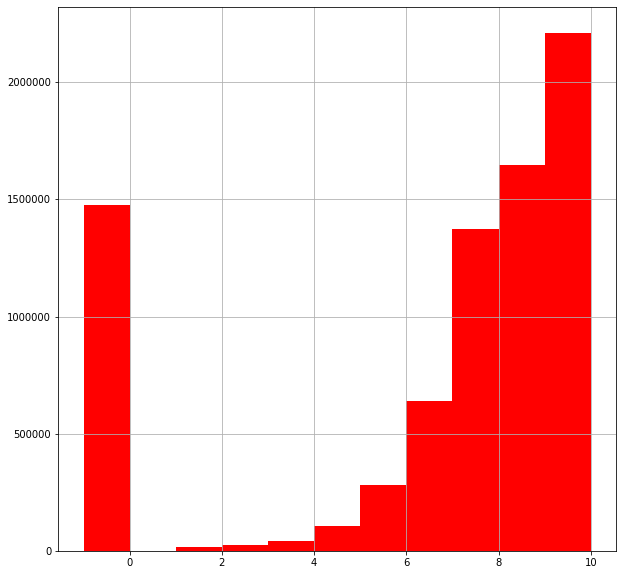

In [11]:
%matplotlib inline
# ratingsのヒストグラムを作成
ratings['rating'].hist(bins=11, figsize=(10,10), color = 'red')

# データの前処理をしよう

In [12]:
# membersの値が10,000より大きいデータのみに変更
anime = anime[anime['members'] > 10000]

In [13]:
# 欠損データの確認
anime.isnull().sum()

anime_id     0
name         0
genre        2
type         4
episodes     0
rating      43
members      0
dtype: int64

In [14]:
# 欠損データをdropna()でデータセットから取り除く
anime = anime.dropna()

In [15]:
# raitingの値が0以上のみ残す
ratings = ratings[ratings.rating >= 0]

In [17]:
round(ratings.describe(), 2)

,user_id,anime_id,rating
count,6337241.00,6337241.00,6337241.00
mean,36747.91,8902.87,7.81
std,21013.40,8882.00,1.57
min,1.00,1.00,1.00
25%,18984.00,1239.00,7.00
50%,36815.00,6213.00,8.00
75%,54873.00,14075.00,9.00
max,73516.00,34475.00,10.00


In [18]:
# animeとratingsの2つのデータフレームをマージさせる
mergeddf = ratings.merge(anime, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
# 合体したデータフレームの最初の5行を表示
mergeddf.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


In [19]:
# mergeddfの基本統計量の確認
round(mergeddf.describe(),2)

,user_id,anime_id,rating_user,rating,members
count,5957004.00,5957004.00,5957004.00,5957004.00,5957004.00
mean,36665.80,9023.38,7.87,7.74,196030.78
std,21030.91,8920.21,1.54,0.62,191317.96
min,1.00,1.00,1.00,2.37,10005.00
25%,18911.00,1195.00,7.00,7.35,57029.00
50%,36534.00,6500.00,8.00,7.74,130689.00
75%,54851.00,14345.00,9.00,8.17,271484.00
max,73516.00,34240.00,10.00,9.37,1013917.00


In [20]:
# 不必要な項目と重複項目を削除
mergeddf = mergeddf[['user_id','name','rating_user']]
mergeddf = mergeddf.drop_duplicates(['user_id','name'])
# head()で最初の5行を表示
mergeddf.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


In [21]:
# データフレームのピボット
anime_pivot = mergeddf.pivot(index= 'name',columns='user_id',values='rating_user').fillna(0)
anime_pivot_sparse = csr_matrix(anime_pivot.values)

In [22]:
# anime_pivotの最初の10行を表示
anime_pivot.head(10)

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Intermezzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Liminality,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Quantum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# k近傍法（k-nearest neighbors）でレコメンド機能を構築

In [23]:
# Scikit-learnのライブラリを利用します
# n_neiborsやalgorithm、metricなど重要なアーギュメントを設定しています
knn = NearestNeighbors(n_neighbors=9,algorithm= 'brute', metric= 'cosine')
# 前処理したデータセットでモデルを訓練
model_knn = knn.fit(anime_pivot_sparse)

# 構築したレコメンド機能を試してみる

In [26]:
# データセットのタイトルをキーワードで検索
def searchanime(string):
    print(anime_pivot[anime_pivot.index.str.contains(string)].index[0:])
searchanime('Hajime')

Index(['Bokura wa Minna Kawaisou: Hajimete no', 'Hajime no Ippo',
       'Hajime no Ippo: Boxer no Kobushi', 'Hajime no Ippo: Champion Road',
       'Hajime no Ippo: Mashiba vs. Kimura', 'Hajime no Ippo: New Challenger',
       'Hajime no Ippo: Rising', 'Kamisama Hajimemashita',
       'Kamisama Hajimemashita OVA', 'Kamisama Hajimemashita: Kako-hen',
       'Kamisama Hajimemashita◎', 'Kyou, Koi wo Hajimemasu',
       'Natsume Yuujinchou: Nyanko-sensei to Hajimete no Otsukai',
       'Re:Petit kara Hajimeru Isekai Seikatsu',
       'Re:Zero kara Hajimeru Break Time',
       'Re:Zero kara Hajimeru Isekai Seikatsu',
       'Sekirei: Hajimete no Otsukai'],
      dtype='object', name='name')


In [27]:
# 「はじめの一歩」に対してのオススメのアニメ10個
Anime = 'Hajime no Ippo'
distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Hajime no Ippo:

1: Hajime no Ippo: New Challenger with distance: 0.16171263372777
2: Hajime no Ippo: Champion Road with distance: 0.30597377816318394
3: Hajime no Ippo: Mashiba vs. Kimura with distance: 0.34948858340614675
4: Hajime no Ippo: Rising with distance: 0.3635742899878238
5: Hajime no Ippo: Boxer no Kobushi with distance: 0.5808237633855784
6: Great Teacher Onizuka with distance: 0.6271421261955552
7: Shijou Saikyou no Deshi Kenichi with distance: 0.6428821544076411
8: Major S1 with distance: 0.6575993793656698
9: Major S2 with distance: 0.6623633646779645
10: One Outs with distance: 0.6644591854339764


In [28]:
# 「君の名は」を見たことがあるあなたにオススメのアニメは・・・
Anime = 'Kimi no Na wa.'
distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Kimi no Na wa.:

1: Boku dake ga Inai Machi with distance: 0.6855242894481091
2: Re:Zero kara Hajimeru Isekai Seikatsu with distance: 0.6968551384446042
3: Shigatsu wa Kimi no Uso with distance: 0.703281384251974
4: ReLIFE with distance: 0.7191316277184874
5: One Punch Man with distance: 0.7426460533821271
6: Charlotte with distance: 0.7434996132820642
7: Noragami Aragoto with distance: 0.7486936229508915
8: Shokugeki no Souma with distance: 0.7585646506908518
9: Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku with distance: 0.7602916580493286
10: Noragami with distance: 0.7612671872707739
